In [1]:
import pandas as pd
import numpy as np
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar as calendarUSFH



# Cargar set de datos

In [2]:
trip_full = pd.read_csv('data/trip.csv')

In [3]:
trip = pd.read_csv('data/trip_train.csv')

In [4]:
trip_test = pd.read_csv('data/trip_test.csv')

In [5]:
weather = pd.read_csv('data/weather.csv')

In [6]:
station = pd.read_csv('data/station.csv')

# Modificando set de datos

In [7]:
trip_test['start_station_name'] = trip_test['start_station_name']\
    .apply(lambda x : 'Washington at Kearney' if x == 'Washington at Kearny' else x  )

In [8]:
trip_test['start_station_name'] = trip_test['start_station_name']\
    .apply(lambda x : 'Post at Kearney' if x == 'Post at Kearny' else x  )

In [9]:
otherStation = pd.DataFrame([['Broadway at Main',94107],['San Jose Government Center',95113]]\
                            ,columns=['station','zip_code'])

In [10]:
stationReduced = station.loc[:,['id','name','city']]

def choseZipCode(city):
    if city == 'San Francisco' : return 94107
    elif city == 'San Jose' : return 95113
    elif city == 'Redwood City' : return 94063
    elif city == 'Palo Alto' : return 94301
    elif city == 'Mountain View' : return 94041

stationReduced['zip_code'] = stationReduced.loc[:,'city'].apply(choseZipCode)

stationReduced = stationReduced.drop(labels=['id','city'],axis=1)
stationReduced.rename(columns={'name':'station'},inplace=True)

In [11]:
stationReduced = stationReduced.append(otherStation,ignore_index=True)

In [12]:
trip.rename(columns={'start_station_name':'station'},inplace=True)


In [13]:
trip_test.rename(columns={'start_station_name':'station'},inplace=True)

In [14]:
trip_test = trip_test.drop(labels=['zip_code','end_date','end_station_name','end_station_id','bike_id'],axis=1)

In [15]:
trip = trip.drop(labels=['zip_code','end_date','end_station_name','end_station_id','bike_id'],axis=1)

In [16]:
weather['precipitation_inches'] = weather['precipitation_inches'].apply(lambda x : 0.005 if (x == 'T') else float(x))

In [17]:

weather = weather[weather.precipitation_inches.isnull() == False]

weather = weather.fillna(0)

weather['events'] = weather['events'].apply(lambda x : 'Normal' if x == 0 else x)
weather['events'] = weather['events'].apply(lambda x : 'Rain' if x == 'rain' else x)
weather['date'] = weather['date'].apply(lambda date : pd.to_datetime(date).date())

In [18]:
weather.events.unique()

array(['Normal', 'Fog', 'Rain', 'Fog-Rain', 'Rain-Thunderstorm'], dtype=object)

In [19]:
weather['Normal'] = weather['events'].apply(lambda x : 1 if x == 'Normal' else 0)

In [20]:
weather['Fog'] = weather['events'].apply(lambda x : 1 if x == 'Fog' else 0)

In [21]:
weather['Rain'] = weather['events'].apply(lambda x : 1 if x == 'Rain' else 0)

In [22]:
weather['Fog-Rain'] = weather['events'].apply(lambda x : 1 if x == 'Fog-Rain' else 0)

In [23]:
weather['Rain-Thunderstorm'] = weather['events'].apply(lambda x : 1 if x == 'Rain-Thunderstorm' else 0)

In [24]:
weather.drop(axis=1,labels='events',inplace=True)

In [25]:
def splitDateAndTime(dateAndTime):
    splitLine = dateAndTime.split(' ')
    return str(splitDate(splitLine[0]))  + splitTime(splitLine[1])

def splitDate(date):
    lineSplit = date.split('/')
    return str(lineSplit[2]) + str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + str(lineSplit[1] if int(lineSplit[1]) >= 10 else '0' + str(lineSplit[1]) )

def splitTime(time):
    lineSplit = time.split(':')
    return str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + str(lineSplit[1])

def hour_to_minute(hourMinute) :
    return int(hourMinute[0:2])* 12  + int(hourMinute[2:4])

In [26]:
trip['time'] = trip['start_date'].apply(lambda x : hour_to_minute(splitDateAndTime(x)[8:12])) 


In [27]:
trip_test['time'] = trip_test['start_date'].apply(lambda x : hour_to_minute(splitDateAndTime(x)[8:12])) 

In [28]:
trip.loc[:,'start_date'] = trip['start_date'].apply(lambda x : pd.to_datetime(splitDateAndTime(x)))


In [29]:
trip_test.loc[:,'start_date'] = trip_test['start_date'].apply(lambda x : pd.to_datetime(splitDateAndTime(x)))

In [30]:
trip.loc[:,'day_of_week'] = trip['start_date'].apply(lambda x : x.dayofweek )


In [31]:
trip_test.loc[:,'day_of_week'] = trip_test['start_date'].apply(lambda x : x.dayofweek )

In [32]:
trip.loc[:,'month'] = trip['start_date'].apply(lambda x : x.month )


In [33]:
trip_test.loc[:,'month'] = trip_test['start_date'].apply(lambda x : x.month )

In [34]:
trip.loc[:,'year'] = trip['start_date'].apply(lambda x : x.year )


In [35]:
trip_test.loc[:,'year'] = trip_test['start_date'].apply(lambda x : x.year )

In [36]:
trip.loc[:,'dayofyear'] = trip['start_date'].apply(lambda x : x.dayofyear )


In [37]:
trip_test.loc[:,'dayofyear'] = trip_test['start_date'].apply(lambda x : x.dayofyear )

In [38]:
trip.loc[:,'start_date'] = trip['start_date'].apply(lambda x : pd.to_datetime(x).date())


In [39]:
trip_test.loc[:,'start_date'] = trip_test['start_date'].apply(lambda x : pd.to_datetime(x).date())

In [40]:
cal = calendarUSFH()
holidays = cal.holidays(return_name=True,start=pd.to_datetime('20130101'), end=pd.to_datetime('20151231'))
holiday_festive_day = pd.DataFrame(holidays,columns=['holiday']).reset_index()
holiday_festive_day.rename(columns={'index':'start_date'},inplace=True)

In [41]:
holiday_festive_day.loc[:,'start_date'] = holiday_festive_day['start_date'].apply(lambda x : pd.to_datetime(x).date())

In [42]:
trip = pd.merge(holiday_festive_day,trip,on=['start_date'],how='right')


In [43]:
trip_test = pd.merge(holiday_festive_day,trip_test,on=['start_date'],how='right')

In [44]:
trip_test.shape

(119998, 11)

In [45]:
trip.loc[:,'is_holiday'] = trip.holiday.isnull()


In [46]:
trip_test.loc[:,'is_holiday'] = trip_test.holiday.isnull()

In [47]:
trip.loc[:,'is_holiday'] = trip['is_holiday'].apply(lambda x : not x )


In [48]:
trip_test.loc[:,'is_holiday'] = trip_test['is_holiday'].apply(lambda x : not x )

In [49]:
trip.loc[:,'subscription_type'] = trip['subscription_type'].apply(lambda x : 0 if ('Subscriber' == x) else 1 )


In [50]:
trip_test.loc[:,'subscription_type'] = trip_test['subscription_type'].apply(lambda x : 0 if ('Subscriber' == x) else 1 )

In [51]:
trip.sample()

,start_date,holiday,id,duration,station,start_station_id,subscription_type,time,day_of_week,month,year,dayofyear,is_holiday
19677,2014-05-20,NaN,291136,179,Beale at Market,56,0,131,1,5,2014,140,False


In [52]:
trip_test.sample()

,start_date,holiday,id,station,start_station_id,subscription_type,time,day_of_week,month,year,dayofyear,is_holiday
43411,2014-02-13,NaN,183476,Embarcadero at Folsom,51,0,190,3,2,2014,44,False


In [53]:
trip_test.shape

(119998, 12)

In [54]:
tripWithZipCode = pd.merge(trip,stationReduced,on=['station'],how='left')


In [55]:
tripWithZipCode_test = pd.merge(trip_test,stationReduced,on=['station'],how='left')

In [56]:
tripWithZipCode_test.shape

(119998, 13)

In [57]:
tripWithZipCode.sample()

,start_date,holiday,id,duration,station,start_station_id,subscription_type,time,day_of_week,month,year,dayofyear,is_holiday,zip_code
488077,2014-12-09,NaN,571285,248,San Francisco Caltrain 2 (330 Townsend),69,0,131,1,12,2014,343,False,94107.0


In [58]:
tripWithZipCode_test.sample()

,start_date,holiday,id,station,start_station_id,subscription_type,time,day_of_week,month,year,dayofyear,is_holiday,zip_code
111521,2015-01-08,NaN,596850,Yerba Buena Center of the Arts (3rd @ Howard),68,0,247,3,1,2015,8,False,94107


In [59]:
tripWithZipCode = tripWithZipCode.drop(labels=['holiday'],axis=1).dropna()


In [60]:
tripWithZipCode_test = tripWithZipCode_test.drop(labels=['holiday'],axis=1)

In [61]:
tripWithZipCode_test.shape

(119998, 12)

In [62]:
tripWithZipCode.rename(columns={'start_date':'date'},inplace=True)

In [63]:
tripWithZipCode_test.rename(columns={'start_date':'date'},inplace=True)

In [64]:
tripWithZipCode_test.shape

(119998, 12)

In [65]:
tripsWithWeather = pd.merge(tripWithZipCode,weather,on=['date','zip_code'],how='left')

In [66]:
tripsWithWeather_test = pd.merge(tripWithZipCode_test,weather,on=['date','zip_code'],how='left')

In [68]:
reduceWeather = weather.drop(labels=['date','zip_code'],axis=1)

In [69]:
for value in reduceWeather.columns :
    tripsWithWeather_test[value] = tripsWithWeather_test[value]\
            .apply(lambda x : tripsWithWeather_test[value].mean() if pd.isnull(x) else x)

In [70]:
tripsWithWeather.rename(columns={'start_station_id':'station_id'},inplace=True)

In [71]:
tripsWithWeather_test.rename(columns={'start_station_id':'station_id'},inplace=True)

In [72]:
tripWithZipCode_test.shape

(119998, 12)

In [73]:
tripsWithWeather = tripsWithWeather.dropna()

In [74]:
tripsWithWeather = tripsWithWeather[tripsWithWeather['duration'] < 1000]

In [75]:
tripsWithWeather.shape

(469526, 39)

In [76]:
tripsWithWeather_test.shape

(119998, 38)

In [77]:
test_id = tripsWithWeather_test['id']

test_target = tripsWithWeather['duration'][-200000:]

In [78]:
train_target = tripsWithWeather['duration']

In [82]:
tripsWithWeatherReduced = tripsWithWeather.drop(labels=['duration','date','station','id'],axis=1)

In [83]:
tripsWithWeatherReduced_test = tripsWithWeather_test.drop(labels=['date','station','id'],axis=1)

In [84]:
train = tripsWithWeatherReduced

In [85]:
test = tripsWithWeatherReduced_test

In [86]:
test_true_duration = pd.DataFrame(trip_full[trip_full.id.isin(trip_test.id.values)]['duration'])
test_true_duration = test_true_duration.reset_index().rename(columns={'index':'id'})

test = tripsWithWeatherReduced[-200000:]

# Reduccion de dimensiones 

In [87]:
from sklearn.decomposition import IncrementalPCA

In [ ]:
pca = IncrementalPCA(n_components=30)

In [ ]:
tripTransform = pca.fit_transform(tripsWithWeatherReduced)

In [90]:
tripTransform_test = pca.fit_transform(tripsWithWeatherReduced_test)

In [91]:
 pd.DataFrame(pca.explained_variance_ratio_).plot()

In [92]:
%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (12, 4)

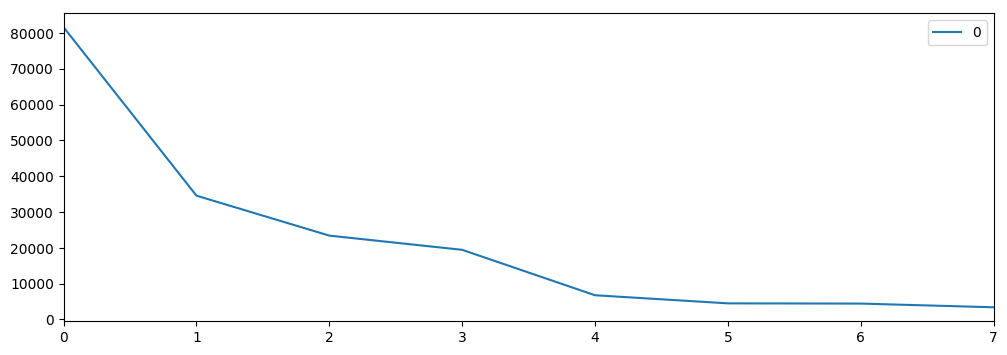

In [94]:
pd.DataFrame(pca.singular_values_).plot()

In [95]:
tripTransform.shape

(469526, 8)

In [96]:
tripTransform_test.shape

(119998, 8)

tripTransformDF = pd.DataFrame(tripTransform)


tripTransformDF_test = pd.DataFrame(tripTransform_test)

tripTransformDF = tripTransformDF.abs()


tripTransformDF_test = tripTransformDF_test.abs()

train = tripTransformDF

test = tripTransformDF[-200000:]

test = tripTransformDF_test

In [97]:

train.shape

(469526, 35)

In [98]:
train_target.shape

(469526,)

# Machine Learning

In [99]:
from sklearn import ensemble

In [100]:
rfr = ensemble.RandomForestRegressor(n_jobs=-1,n_estimators=1000,criterion='mse',
           min_samples_split=500,warm_start=True,verbose=10)

In [101]:
rfr.fit(train,train_target)

building tree 1 of 1000
building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000


building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.8s


building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.1s


building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.2s


building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   56.1s


building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min


building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.1min


building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min


building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.0min


building tree 81 of 1000
building tree 82 of 1000
building tree 83 of 1000
building tree 84 of 1000
building tree 85 of 1000
building tree 86 of 1000
building tree 87 of 1000
building tree 88 of 1000
building tree 89 of 1000
building tree 90 of 1000
building tree 91 of 1000
building tree 92 of 1000
building tree 93 of 1000


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.6min


building tree 94 of 1000
building tree 95 of 1000
building tree 96 of 1000
building tree 97 of 1000
building tree 98 of 1000
building tree 99 of 1000
building tree 100 of 1000
building tree 101 of 1000
building tree 102 of 1000
building tree 103 of 1000
building tree 104 of 1000
building tree 105 of 1000
building tree 106 of 1000
building tree 107 of 1000
building tree 108 of 1000


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.2min


building tree 109 of 1000
building tree 110 of 1000
building tree 111 of 1000
building tree 112 of 1000
building tree 113 of 1000
building tree 114 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.7min


building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.5min


building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000
building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 153 of 1000
building tree 154 of 1000
building tree 155 of 1000
building tree 156 of 1000
building tree 157 of 1000
building tree 158 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.1min


building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  6.8min


building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min


building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000
building tree 208 of 1000
building tree 209 of 1000
building tree 210 of 1000
building tree 211 of 1000
building tree 212 of 1000
building tree 213 of 1000
building tree 214 of 1000
building tree 215 of 1000
building tree 216 of 1000


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  8.4min


building tree 217 of 1000
building tree 218 of 1000
building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tree 226 of 1000
building tree 227 of 1000
building tree 228 of 1000
building tree 229 of 1000
building tree 230 of 1000
building tree 231 of 1000
building tree 232 of 1000
building tree 233 of 1000
building tree 234 of 1000
building tree 235 of 1000
building tree 236 of 1000
building tree 237 of 1000


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  9.3min


building tree 238 of 1000
building tree 239 of 1000
building tree 240 of 1000
building tree 241 of 1000
building tree 242 of 1000
building tree 243 of 1000
building tree 244 of 1000
building tree 245 of 1000
building tree 246 of 1000
building tree 247 of 1000
building tree 248 of 1000
building tree 249 of 1000
building tree 250 of 1000
building tree 251 of 1000
building tree 252 of 1000
building tree 253 of 1000
building tree 254 of 1000
building tree 255 of 1000
building tree 256 of 1000
building tree 257 of 1000
building tree 258 of 1000
building tree 259 of 1000
building tree 260 of 1000


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 10.2min


building tree 261 of 1000
building tree 262 of 1000
building tree 263 of 1000
building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 270 of 1000
building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 275 of 1000
building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 11.1min


building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed: 12.1min


building tree 309 of 1000
building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000
building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed: 13.1min


building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.2min


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 15.2min


building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tree 400 of 1000
building tree 401 of 1000
building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000
building tree 405 of 1000
building tree 406 of 1000
building tree 407 of 1000
building tree 408 of 1000
building tree 409 of 1000
building tree 410 of 1000
building tree 411 of 1000
building tree 412 of 1000
building tree 413 of 1000
building tree 414 of 1000
building tree 415 of 1000
building tree 416 of 1000


[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 16.4min


building tree 417 of 1000
building tree 418 of 1000
building tree 419 of 1000
building tree 420 of 1000
building tree 421 of 1000
building tree 422 of 1000
building tree 423 of 1000
building tree 424 of 1000
building tree 425 of 1000
building tree 426 of 1000
building tree 427 of 1000
building tree 428 of 1000
building tree 429 of 1000
building tree 430 of 1000
building tree 431 of 1000
building tree 432 of 1000
building tree 433 of 1000
building tree 434 of 1000
building tree 435 of 1000
building tree 436 of 1000
building tree 437 of 1000
building tree 438 of 1000
building tree 439 of 1000
building tree 440 of 1000
building tree 441 of 1000
building tree 442 of 1000
building tree 443 of 1000
building tree 444 of 1000
building tree 445 of 1000


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.5min


building tree 446 of 1000
building tree 447 of 1000
building tree 448 of 1000
building tree 449 of 1000
building tree 450 of 1000
building tree 451 of 1000
building tree 452 of 1000
building tree 453 of 1000
building tree 454 of 1000
building tree 455 of 1000
building tree 456 of 1000
building tree 457 of 1000
building tree 458 of 1000
building tree 459 of 1000
building tree 460 of 1000
building tree 461 of 1000
building tree 462 of 1000
building tree 463 of 1000
building tree 464 of 1000
building tree 465 of 1000
building tree 466 of 1000
building tree 467 of 1000
building tree 468 of 1000
building tree 469 of 1000
building tree 470 of 1000
building tree 471 of 1000
building tree 472 of 1000
building tree 473 of 1000
building tree 474 of 1000
building tree 475 of 1000
building tree 476 of 1000


[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed: 18.8min


building tree 477 of 1000
building tree 478 of 1000
building tree 479 of 1000
building tree 480 of 1000
building tree 481 of 1000
building tree 482 of 1000
building tree 483 of 1000
building tree 484 of 1000
building tree 485 of 1000
building tree 486 of 1000
building tree 487 of 1000
building tree 488 of 1000
building tree 489 of 1000
building tree 490 of 1000
building tree 491 of 1000
building tree 492 of 1000
building tree 493 of 1000
building tree 494 of 1000
building tree 495 of 1000
building tree 496 of 1000
building tree 497 of 1000
building tree 498 of 1000
building tree 499 of 1000
building tree 500 of 1000
building tree 501 of 1000
building tree 502 of 1000
building tree 503 of 1000
building tree 504 of 1000
building tree 505 of 1000
building tree 506 of 1000
building tree 507 of 1000


[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 19.9min


building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000


[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 21.2min


building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000
building tree 548 of 1000
building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tree 553 of 1000
building tree 554 of 1000
building tree 555 of 1000
building tree 556 of 1000
building tree 557 of 1000
building tree 558 of 1000
building tree 559 of 1000
building tree 560 of 1000
building tree 561 of 1000
building tree 562 of 1000
building tree 563 of 1000
building tree 564 of 1000
building tree 565 of 1000
building tree 566 of 1000
building tree 567 of 1000
building tree 568 of 1000
building tree 569 of 1000
building tree 570 of 1000
building tree 571 of 1000
building tree 572 of 1000
building tree 573 of 1000
building tree 574 of 1000


[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 22.5min


building tree 575 of 1000
building tree 576 of 1000
building tree 577 of 1000
building tree 578 of 1000
building tree 579 of 1000
building tree 580 of 1000
building tree 581 of 1000
building tree 582 of 1000
building tree 583 of 1000
building tree 584 of 1000
building tree 585 of 1000
building tree 586 of 1000
building tree 587 of 1000
building tree 588 of 1000
building tree 589 of 1000
building tree 590 of 1000
building tree 591 of 1000
building tree 592 of 1000
building tree 593 of 1000
building tree 594 of 1000
building tree 595 of 1000
building tree 596 of 1000
building tree 597 of 1000
building tree 598 of 1000
building tree 599 of 1000
building tree 600 of 1000
building tree 601 of 1000
building tree 602 of 1000
building tree 603 of 1000
building tree 604 of 1000
building tree 605 of 1000
building tree 606 of 1000
building tree 607 of 1000
building tree 608 of 1000


[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 23.8min


building tree 609 of 1000
building tree 610 of 1000
building tree 611 of 1000
building tree 612 of 1000
building tree 613 of 1000
building tree 614 of 1000
building tree 615 of 1000
building tree 616 of 1000
building tree 617 of 1000
building tree 618 of 1000
building tree 619 of 1000
building tree 620 of 1000
building tree 621 of 1000
building tree 622 of 1000
building tree 623 of 1000
building tree 624 of 1000
building tree 625 of 1000
building tree 626 of 1000
building tree 627 of 1000
building tree 628 of 1000
building tree 629 of 1000
building tree 630 of 1000
building tree 631 of 1000
building tree 632 of 1000
building tree 633 of 1000
building tree 634 of 1000
building tree 635 of 1000
building tree 636 of 1000
building tree 637 of 1000
building tree 638 of 1000
building tree 639 of 1000
building tree 640 of 1000
building tree 641 of 1000
building tree 642 of 1000
building tree 643 of 1000


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 25.1min


building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000


[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 26.6min


building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000
building tree 703 of 1000
building tree 704 of 1000
building tree 705 of 1000
building tree 706 of 1000
building tree 707 of 1000
building tree 708 of 1000
building tree 709 of 1000
building tree 710 of 1000
building tree 711 of 1000
building tree 712 of 1000
building tree 713 of 1000
building tree 714 of 1000
building tree 715 of 1000
building tree 716 of 1000
building tree 717 of 1000


[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 28.0min


building tree 718 of 1000
building tree 719 of 1000
building tree 720 of 1000
building tree 721 of 1000
building tree 722 of 1000
building tree 723 of 1000
building tree 724 of 1000
building tree 725 of 1000
building tree 726 of 1000
building tree 727 of 1000
building tree 728 of 1000
building tree 729 of 1000
building tree 730 of 1000
building tree 731 of 1000
building tree 732 of 1000
building tree 733 of 1000
building tree 734 of 1000
building tree 735 of 1000
building tree 736 of 1000
building tree 737 of 1000
building tree 738 of 1000
building tree 739 of 1000
building tree 740 of 1000
building tree 741 of 1000
building tree 742 of 1000
building tree 743 of 1000
building tree 744 of 1000
building tree 745 of 1000
building tree 746 of 1000
building tree 747 of 1000
building tree 748 of 1000
building tree 749 of 1000
building tree 750 of 1000
building tree 751 of 1000
building tree 752 of 1000
building tree 753 of 1000
building tree 754 of 1000
building tree 755 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 29.5min


building tree 757 of 1000
building tree 758 of 1000
building tree 759 of 1000
building tree 760 of 1000
building tree 761 of 1000
building tree 762 of 1000
building tree 763 of 1000
building tree 764 of 1000
building tree 765 of 1000
building tree 766 of 1000
building tree 767 of 1000
building tree 768 of 1000
building tree 769 of 1000
building tree 770 of 1000
building tree 771 of 1000
building tree 772 of 1000
building tree 773 of 1000
building tree 774 of 1000
building tree 775 of 1000
building tree 776 of 1000
building tree 777 of 1000
building tree 778 of 1000
building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tree 787 of 1000
building tree 788 of 1000
building tree 789 of 1000
building tree 790 of 1000
building tree 791 of 1000
building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.0min


building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000
building tree 817 of 1000
building tree 818 of 1000
building tree 819 of 1000
building tree 820 of 1000
building tree 821 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tree 826 of 1000
building tree 827 of 1000
building tree 828 of 1000
building tree 829 of 1000
building tree 830 of 1000
building tree 831 of 1000
building tree 832 of 1000
building tree 833 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 32.6min


building tree 837 of 1000
building tree 838 of 1000
building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000
building tree 842 of 1000
building tree 843 of 1000
building tree 844 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tree 854 of 1000
building tree 855 of 1000
building tree 856 of 1000
building tree 857 of 1000
building tree 858 of 1000
building tree 859 of 1000
building tree 860 of 1000
building tree 861 of 1000
building tree 862 of 1000
building tree 863 of 1000
building tree 864 of 1000
building tree 865 of 1000
building tree 866 of 1000
building tree 867 of 1000
building tree 868 of 1000
building tree 869 of 1000
building tree 870 of 1000
building tree 871 of 1000
building tree 872 of 1000
building tree 873 of 1000
building tree 874 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 34.2min


building tree 878 of 1000
building tree 879 of 1000
building tree 880 of 1000
building tree 881 of 1000
building tree 882 of 1000
building tree 883 of 1000
building tree 884 of 1000
building tree 885 of 1000
building tree 886 of 1000
building tree 887 of 1000
building tree 888 of 1000
building tree 889 of 1000
building tree 890 of 1000
building tree 891 of 1000
building tree 892 of 1000
building tree 893 of 1000
building tree 894 of 1000
building tree 895 of 1000
building tree 896 of 1000
building tree 897 of 1000
building tree 898 of 1000
building tree 899 of 1000
building tree 900 of 1000
building tree 901 of 1000
building tree 902 of 1000
building tree 903 of 1000
building tree 904 of 1000
building tree 905 of 1000
building tree 906 of 1000
building tree 907 of 1000
building tree 908 of 1000
building tree 909 of 1000
building tree 910 of 1000
building tree 911 of 1000
building tree 912 of 1000
building tree 913 of 1000
building tree 914 of 1000
building tree 915 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 35.9min


building tree 921 of 1000
building tree 922 of 1000
building tree 923 of 1000
building tree 924 of 1000
building tree 925 of 1000
building tree 926 of 1000
building tree 927 of 1000
building tree 928 of 1000
building tree 929 of 1000
building tree 930 of 1000
building tree 931 of 1000
building tree 932 of 1000
building tree 933 of 1000
building tree 934 of 1000
building tree 935 of 1000
building tree 936 of 1000
building tree 937 of 1000
building tree 938 of 1000
building tree 939 of 1000
building tree 940 of 1000
building tree 941 of 1000
building tree 942 of 1000
building tree 943 of 1000
building tree 944 of 1000
building tree 945 of 1000
building tree 946 of 1000
building tree 947 of 1000
building tree 948 of 1000
building tree 949 of 1000
building tree 950 of 1000
building tree 951 of 1000
building tree 952 of 1000
building tree 953 of 1000
building tree 954 of 1000
building tree 955 of 1000
building tree 956 of 1000
building tree 957 of 1000
building tree 958 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 37.6min


building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 39.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=10, warm_start=True)

In [102]:
test_prediction = rfr.predict(test)

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Do

In [104]:
mean_squared_error(test_true_duration['duration'],test_prediction)

43133050.084203444

### Conversion para entrega

In [105]:
predictionDF = pd.DataFrame(test_prediction,columns={"duration"})

In [106]:
predictionDF.loc[:,'id'] = test_id.values

In [107]:
predictionDF.to_csv(path_or_buf='prediction_rfr_pca_1',sep=',',header=True,columns=['id','duration'],index=False)

### CrossValidation
#### En caso de querer usar parte del set de entrenamiento como set de prueba 

rfr.score(test,test_target)

from sklearn.metrics import mean_squared_error

mean_squared_error(test_target,test_prediction)

En caso de ser necesario de Cross Validation

predictionDF = pd.DataFrame(test_prediction,columns={"prediction"})

predictionDF.loc[:,'spectate'] = test_target.values

def predictError(predict,spectate):
    if (spectate > predict) : return  ((spectate-predict)/spectate)*100
    else  :  return ((predict-spectate)/predict )*100

predictionDF['errorValue'] = predictionDF.apply(axis=1,func=lambda x : predictError(x[0],x[1]))

predictionDF.sample(5)

print 'El error promedio que comete Random Forest Regresion al predecir es de', float(predictionDF['errorValue'].mean()),'%'

print "El algoritmo Random Forest Regresion predice un ",\
float(predictionDF[predictionDF['errorValue'] < 15].shape[0]) / float(predictionDF.shape[0]) *100 ,\
"% de los valores, con un error menor al 15%"


predictionDF.describe()